In [75]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import torch
import re


In [76]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [77]:
dataset_path=r"data\images\google_images"

In [78]:
labels_dict = dict(
   img_path=[],  
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[],
    name=[]
)

In [79]:
xml_files = glob(f'{dataset_path}/*.xml')

In [80]:
for filename in xml_files:
    try:
        # Parse the XML file
        info = ET.parse(filename)
        root = info.getroot()
        
        # Extract the image filename and construct the full path
        img_name = root.find('filename').text
        img_path = os.path.join(dataset_path, img_name)  # Use <path> for full path if available
        
        # Extract image dimensions from <size>
        size_info = root.find('size')
        img_w = int(size_info.find('width').text)
        img_h = int(size_info.find('height').text)
        
        # Check if there are any <object> elements
        objects_found = False
        for member_object in root.findall('object'):
            objects_found = True
            labels_info = member_object.find('bndbox')
            xmin = int(labels_info.find('xmin').text)
            ymin = int(labels_info.find('ymin').text)
            xmax = int(labels_info.find('xmax').text)
            ymax = int(labels_info.find('ymax').text)
            name = member_object.find('name').text
            
            # Append the extracted information to the dictionary
            labels_dict['img_path'].append(img_path)
            labels_dict['xmin'].append(xmin)
            labels_dict['xmax'].append(xmax)
            labels_dict['ymin'].append(ymin)
            labels_dict['ymax'].append(ymax)
            labels_dict['img_w'].append(img_w)
            labels_dict['img_h'].append(img_h)
            labels_dict['name'].append(name)
        
        if not objects_found:
            print(f"Warning: No <object> found in {filename}")
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
print(alldata)


                                               img_path  xmin  xmax  ymin  \
0     data\images\google_images\0073797c-a755-4972-b...   140   339   210   
1     data\images\google_images\00b42b2c-f193-4863-b...   184   292   572   
2     data\images\google_images\018b52e6-e9a1-42c2-8...   327   399   202   
3     data\images\google_images\03273806-bb1e-48da-8...   185   374   290   
4     data\images\google_images\0369b20e-b432-4409-9...   335   453   313   
...                                                 ...   ...   ...   ...   
1684                  data\images\google_images\WB4.jpg   119   191   268   
1685                  data\images\google_images\WB5.jpg   105   187   256   
1686                  data\images\google_images\WB6.jpg   108   181   247   
1687                  data\images\google_images\WB8.jpg    98   184   210   
1688                  data\images\google_images\WB9.jpg    92   152   204   

      ymax  img_w  img_h        name  
0      260    500    335    KA19TR02

In [86]:
# Filter grouped_counts to include only rows where count is less than 3
filtered_counts = grouped_counts[grouped_counts['count'] < 3]

print(filtered_counts)

   name_prefix  count
9           DU      1
18          LA      1
23          MZ      1


In [82]:
alldata['name_prefix'] = alldata['name'].str[:2]

# Group by the first two letters and count occurrences
grouped_counts = alldata.groupby('name_prefix').size().reset_index(name='count')

# Filter out name_prefixes with count == 1
valid_prefixes = grouped_counts[grouped_counts['count'] > 3]['name_prefix']

# Drop rows from alldata where name_prefix is not in valid_prefixes
filtered_alldata = alldata[alldata['name_prefix'].isin(valid_prefixes)]

print(filtered_alldata)

0     AN
1     AP
2     AR
3     AS
4     BR
5     CG
6     CH
7     DL
8     DN
10    GA
11    GJ
12    HP
13    HR
14    JH
15    JK
16    KA
17    KL
19    MH
20    ML
21    MN
22    MP
24    NL
25    OD
26    OR
27    PB
28    PY
29    RJ
30    SK
31    TN
32    TR
33    TS
34    UK
35    UP
36    WB
Name: name_prefix, dtype: object
                                               img_path  xmin  xmax  ymin  \
0     data\images\google_images\0073797c-a755-4972-b...   140   339   210   
1     data\images\google_images\00b42b2c-f193-4863-b...   184   292   572   
2     data\images\google_images\018b52e6-e9a1-42c2-8...   327   399   202   
3     data\images\google_images\03273806-bb1e-48da-8...   185   374   290   
4     data\images\google_images\0369b20e-b432-4409-9...   335   453   313   
...                                                 ...   ...   ...   ...   
1684                  data\images\google_images\WB4.jpg   119   191   268   
1685                  data\images\google_imag

In [70]:
from sklearn.model_selection import train_test_split
import pandas as pd

def stratified_split(dataframe, train_size=0.7, val_size=0.15, test_size=0.15):
    # Validate split sizes
    if not (0 < train_size < 1 and 0 < val_size < 1 and 0 < test_size < 1):
        raise ValueError("train_size, val_size, and test_size must be between 0 and 1.")
    if abs(train_size + val_size + test_size - 1) > 1e-6:
        raise ValueError("train_size, val_size, and test_size must sum to 1.")

    # Extract the first two letters of each name
    dataframe['name_prefix'] = dataframe['name'].str[:2]

    # Identify unique name prefixes
    unique_prefixes = dataframe['name_prefix'].unique()
   

    # Initialize empty DataFrames for train, val, and test
    train = pd.DataFrame()
    val = pd.DataFrame()
    test = pd.DataFrame()

    # Ensure at least one sample of each prefix is in train, val, and test
    for prefix in unique_prefixes:
        prefix_data = dataframe[dataframe['name_prefix'] == prefix]

        # Split the data for this prefix
        prefix_train, prefix_temp = train_test_split(
            prefix_data,
            test_size=1 - train_size,
            random_state=42
        )
        prefix_val, prefix_test = train_test_split(
            prefix_temp,
            test_size=test_size / (val_size + test_size),
            random_state=42
        )

        # Append to the respective splits
        train = pd.concat([train, prefix_train])
        val = pd.concat([val, prefix_val])
        test = pd.concat([test, prefix_test])

    # Drop the temporary 'name_prefix' column
    train = train.drop(columns=['name_prefix'])
    val = val.drop(columns=['name_prefix'])
    test = test.drop(columns=['name_prefix'])

    # Shuffle the splits to avoid ordering bias
    train = train.sample(frac=1, random_state=42).reset_index(drop=True)
    val = val.sample(frac=1, random_state=42).reset_index(drop=True)
    test = test.sample(frac=1, random_state=42).reset_index(drop=True)

    return {
        'train': train,
        'val': val,
        'test': test
    }

In [55]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format,
    further separating the folders by state based on the first two characters of the 'name' column.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under
    'datasets/cars_license_plate/{split_name}/{state}',
    and save the corresponding labels and images in YOLO format.
    """
    base_path = os.path.join('datasets', 'cars_license_plate_new', split_name)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        try:
            # Extract state from the first two characters of the 'name' column
            state = row['name'][:2]
            
            # Paths for labels and images
            state_path = os.path.join(base_path, state)
            labels_path = os.path.join(state_path, 'labels')
            images_path = os.path.join(state_path, 'images')
            
            # Create directories for labels and images if they don't exist
            os.makedirs(labels_path, exist_ok=True)
            os.makedirs(images_path, exist_ok=True)
            
            # Extract image name and extension
            img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
            
            # Calculate YOLO format bounding box coordinates
            x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
            y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
            width = (row['xmax'] - row['xmin']) / row['img_w']
            height = (row['ymax'] - row['ymin']) / row['img_h']

            # Save the label in YOLO format
            label_path = os.path.join(labels_path, f'{img_name}.txt')
            with open(label_path, 'w') as file:
                file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
                
            # Check if the image file exists before copying
            if os.path.exists(row['img_path']):
                shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
            else:
                print(f"Warning: Image file not found - {row['img_path']}")
        
        except Exception as e:
            print(f"Error processing row {row['name']}: {e}")
    
    print(f"Created folders under '{base_path}' organized by state.")

# Example usage:
# Assuming `df` is a DataFrame with columns: ['img_path', 'xmin', 'xmax', 'ymin', 'ymax', 'img_w', 'img_h', 'name']


In [56]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [57]:
splits = stratified_split(filtered_alldata)
for split_name, split_df in splits.items():
    make_split_folder_in_yolo_format(split_name, split_df)

C:\Users\garvi\AppData\Local\Temp\ipykernel_4888\2059619955.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['name_prefix'] = dataframe['name'].str[:2]


Created folders under 'datasets\cars_license_plate_new\train' organized by state.
Created folders under 'datasets\cars_license_plate_new\val' organized by state.
Created folders under 'datasets\cars_license_plate_new\test' organized by state.


In [65]:

def count_folders_in_directory(directory_path):
    # List all items in the directory and filter only directories
    return len([f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))])

directory_path = r'datasets\cars_license_plate_new\val'  
folder_count = count_folders_in_directory(directory_path)
print(f"Number of folders: {folder_count}")


Number of folders: 34


In [59]:
import os

# List of states
states = [
    'AN', 'AP', 'AR', 'AS', 'BR', 'CG', 'CH', 'DL', 'DN', 'DU', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'OD', 'PB', 'PY', 'RJ', 'SK', 'TN', 'TR', 'TS', 'UK', 'UP', 'WB',
]

# Base path for datasets
base_path = "D:/codes/ML/deteciton v11/datasets/cars_license_plate_new"

# Directory to save YAML files
yaml_dir = "datasets_yaml"

# Create the directory if it doesn't exist
os.makedirs(yaml_dir, exist_ok=True)

# Class names
class_names = ['license_plate']  # Add more classes if applicable.

def create_yaml(state):
    # Paths for images and labels
    train_path = os.path.join(base_path, "train", state, "images")
    val_path = os.path.join(base_path, "val", state, "images")
    test_path = os.path.join(base_path, "test", state, "images")

    train_labels_path = os.path.join(base_path, "train", state, "labels")
    val_labels_path = os.path.join(base_path, "val", state, "labels")
    test_labels_path = os.path.join(base_path, "test", state, "labels")

    # Check if validation data exists
    if os.path.exists(val_path) and os.path.exists(val_labels_path):
        val_entry = f"val: {val_path}\nval_labels: {val_labels_path}"
    else:
        val_entry = ""

    # Check if test data exists
    if os.path.exists(test_path) and os.path.exists(test_labels_path):
        test_entry = f"test: {test_path}\ntest_labels: {test_labels_path}"
    else:
        test_entry = "test: []\ntest_labels: []"

    # YAML content
    yaml_content = f"""
train: {train_path}
{val_entry}
{test_entry}

train_labels: {train_labels_path}
val_labels: {val_labels_path}
test_labels: {test_labels_path}

# Number of classes
nc: {len(class_names)}

# Class names
names: {class_names}
"""

    # Write to a YAML file in the specified directory
    yaml_path = os.path.join(yaml_dir, f"{state}.yaml")
    with open(yaml_path, 'w') as file:
        file.write(yaml_content.strip())


In [62]:
# get an image file for fixing boundary box
image_dir='datasets/cars_license_plate_new/train/AP/images'
labels_dir='datasets/cars_license_plate_new/train/AP/labels'

image_files=sorted(os.listdir(image_dir))
first_image_file=image_files[2]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(labels_dir, os.path.splitext(first_image_file)[0] + '.txt')

image=cv2.imread(image_path)

image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
with open(label_path,'r') as f:
    lines=f.readlines()
    

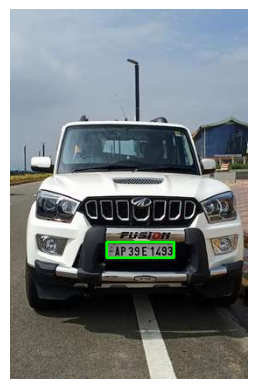

In [63]:

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape
    
    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    
    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    
    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# After the loop, display the image with all bounding boxes
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image


In [71]:
from ultralytics import YOLO

In [72]:
from ultralytics import YOLO
import os

# Directory containing state-specific YAML files
yaml_dir = "./datasets_yaml/"

# Directory to save weights
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)

# Initial weights
initial_weights = "yolo11n.pt"  # Ensure this file exists
current_weights = initial_weights

# Iterate through all YAML files in the directory
for yaml_file in sorted(os.listdir(yaml_dir)):
    if yaml_file.endswith(".yaml"):
        yaml_path = os.path.join(yaml_dir, yaml_file)  # Correct path construction
        state_name = os.path.splitext(yaml_file)[0]

        print(f"Training for state: {state_name}")
        print(f"Using weights: {current_weights}")

        # Initialize the YOLO model
        model = YOLO(current_weights)

        # Train the model
        model.train(
            data=yaml_path,
            epochs=10,  # Adjust epochs as needed
            project="state_training",
            name=state_name,
            save_period=1,  # Save weights periodically
            save_dir=os.path.join(weights_dir, state_name)
        )

        # Update current_weights for the next iteration
        current_weights = os.path.cjoin(weights_dir, state_name, "weights", "best.pt")

print("State-wise training completed.")


Training for state: AN
Using weights: yolo11n.pt
New https://pypi.org/project/ultralytics/8.3.70 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.58  Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=./datasets_yaml/AN.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=state_training, name=AN17, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning D:\codes\ML\deteciton v11\datasets\cars_license_plate_new\train\AN\labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 212.14it/s]

train: New cache created: D:\codes\ML\deteciton v11\datasets\cars_license_plate_new\train\AN\labels.cache




KeyboardInterrupt

